In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from numpy import inf

#powerlaw fitting
import powerlaw

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [113]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
dico_night_hour = config.dico_night_hour
dico_garden_opening_hour = config.dico_garden_opening_hour
print(id_run)
path_cluster = os.path.join(path_extracted_data,'clustering')
#create a director if not existing
if not os.path.exists(path_cluster):
    os.makedirs(path_cluster)
path_visual = os.path.join(path_extracted_data,'visual')

change the configuration file if not done yet!
correctlightschedule_


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download variables

In [4]:
#for being more reproductible, we open the file that was saved from cleaning
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';', 
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                              'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 
                              'Nestbox_time_of_first_staid_longer_than900sec'], dayfirst=True) 
print(df_daily.shape)
display(df_daily.head(3))
df_daily.tail(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (103) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,level,DOA,WOA
42512,2021-01-29,240,35
42513,2021-02-25,267,39
42514,2021-03-28,298,43


(42287, 149)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,temperature_night20_2_median,temperature_night20_2_max,temperature_night20_2_var,list_of_MovementCounter_day,len_MovementCounter_day,MovementCounter_day_amount_nnactivity,MovementCounter_day_max,MovementCounter_day_mean,DOA,WOA
0,hen_130,2020-10-04,0.0,140.0,1166.0,79.0,30613.0,31998.0,"[0.0, 140.0, 1166.0, 79.0, 30613.0]","[0.0, 0.004375273454590912, 0.0364397774860928...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123,18
1,hen_130,2020-10-05,0.0,0.0,0.0,0.0,32400.0,32400.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124,18
2,hen_130,2020-10-06,0.0,0.0,780.0,325.0,31295.0,32400.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]","[0.0, 0.0, 0.024074074074074074, 0.01003086419...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,125,18


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,temperature_night20_2_median,temperature_night20_2_max,temperature_night20_2_var,list_of_MovementCounter_day,len_MovementCounter_day,MovementCounter_day_amount_nnactivity,MovementCounter_day_max,MovementCounter_day_mean,DOA,WOA
42512,hen_98,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240,35
42513,hen_98,2021-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,267,39
42514,hen_98,2021-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,298,43


In [63]:
#Verify: 01.06: no more transitions! when it started? write on focal birds and rerun all. as the bird lost his tag before 02.06 but we do not know when
#TODO: REMOVE FROM FOCAL BIRDS???but stoped location at 01.06.2021 04:04
df_daily[(df_daily['HenID']=='hen_52')&(df_daily['Total_number_transition']==0)]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,MovementCounter_day_max,MovementCounter_day_mean,DOA,WOA,nbr_sec_per_day,nbr_h_per_day,verification_daily_total_nbr_hour,correct_amount_of_hour,DIB,WIB
34598,hen_52,2020-10-15,0.0,0.0,0.0,0.0,36000.0,36000.0,"[0.0, 0.0, 0.0, 0.0, 36000.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",...,80.0,63.065000,134,20,10,10,10.0,True,16,3
34599,hen_52,2020-10-16,0.0,0.0,0.0,0.0,39600.0,39600.0,"[0.0, 0.0, 0.0, 0.0, 39600.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",...,93.0,67.286364,135,20,11,11,11.0,True,17,3
34600,hen_52,2020-10-17,0.0,0.0,0.0,0.0,39600.0,39600.0,"[0.0, 0.0, 0.0, 0.0, 39600.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",...,88.6,72.583333,136,20,11,11,11.0,True,18,3


In [5]:
#display(df_daily[df_daily['TagID']=='tag_80'][['HenID','level','TagID','duration_5_Zone']])
#df_daily[df_daily['HenID']=='hen_171'][['HenID','level','TagID','duration_5_Zone']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#list(df_daily.columns)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# verify DIB, DOA

In [37]:
display(df_daily[['level','HenID','DOA','WOA','DIB','WIB','verification_daily_total_nbr_hour','nbr_h_per_day','duration_5_Zone',
                 'duration_4_Zone','duration_3_Zone','duration_2_Zone','duration_1_Zone']].tail(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,HenID,DOA,WOA,DIB,WIB,verification_daily_total_nbr_hour,nbr_h_per_day,duration_5_Zone,duration_4_Zone,duration_3_Zone,duration_2_Zone,duration_1_Zone
42512,2021-01-29,hen_98,240,35,122,18,NaN,15,NaN,NaN,NaN,NaN,NaN
42513,2021-02-25,hen_98,267,39,149,22,NaN,15,NaN,NaN,NaN,NaN,NaN
42514,2021-03-28,hen_98,298,43,180,26,NaN,15,NaN,NaN,NaN,NaN,NaN


# Health variable

### small investigation

In [9]:
df_FB = pd.read_csv(os.path.join(path_extracted_data,id_run+'df_FOCALBIRDS.csv'), sep=';')
print(df_FB.shape)
df_FB.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(228, 12)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,Treatment
0,hen_1,9,EPI,1.0,10.06.2020,1134.0,57.0,1696.5,1787.8,1800.9,NaN,OFH
1,hen_10,11,LEXP,1.0,10.06.2020,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,OFH
2,hen_100,5,EPI,3.0,10.06.2020,1182.0,80.5,1642.5,NaN,NaN,NaN,OFH


In [10]:
#removed pen 12!!! due to 'weight 04-01-2021', so we will keep nan there
li_weight = [v for v in df_daily.columns if 'weight' in v]
df_wei = df_FB[['HenID','PenID','Treatment','CLASS']+li_weight].copy()
df_wei.dropna(subset=[n for n in df_wei if n != 'weight 04-01-2021'], inplace=True)
#df_wei = df_wei[~df_wei.isnull().any(axis=1)]
print(df_wei.shape)
display(df_wei['PenID'].value_counts())
df_wei.head(3)

(93, 10)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


10    13
3     13
12    12
4     12
9     11
8     11
5     11
11    10
Name: PenID, dtype: int64

,HenID,PenID,Treatment,CLASS,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21
1,hen_10,11,OFH,LEXP,1070.0,70.4,1488.3,1628.4,1602.1,1587.2
3,hen_101,5,OFH,MEXP,1082.0,66.0,1625.7,1751.1,1723.4,1762.5
4,hen_102,3,OFH,MEXP,1158.0,68.8,1855.1,2013.3,2142.7,2112.5


In [11]:
#we wont use: weight 04-01-2021 as missing pen 12!
df_wei['weight_DOA37-39_div_DOA118'] = df_wei['10-12 juin weight']/df_wei['29-09 weight']
df_wei['weight_DOA37-39_div_DOA243'] = df_wei['10-12 juin weight']/df_wei['weight 01-02-21']
df_wei['weight_DOA118_div_DOA173'] = df_wei['29-09 weight']/df_wei['weight 23-11-2020']
df_wei['weight_DOA118_div_DOA243'] = df_wei['29-09 weight']/df_wei['weight 01-02-21']
df_wei['weight_DOA173_div_DOA243'] = df_wei['weight 23-11-2020']/df_wei['weight 01-02-21']

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


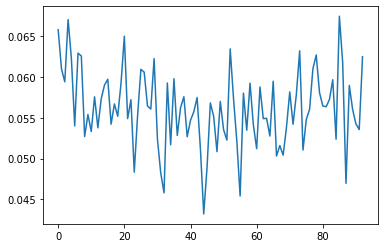

In [12]:
plt.plot(df_wei['weight_DOA37-39_div_DOA118'].tolist());

In [13]:
df_w = pd.melt(df_wei, id_vars=['HenID','PenID','Treatment','CLASS'], value_vars=li_weight)
print(df_w.shape)
df_w.head(3)

(558, 6)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,Treatment,CLASS,variable,value
0,hen_10,11,OFH,LEXP,29-09 weight,1070.0
1,hen_101,5,OFH,MEXP,29-09 weight,1082.0
2,hen_102,3,OFH,MEXP,29-09 weight,1158.0


In [14]:
#add to our daily variable
#we wont use: weight 04-01-2021 as missing pen 12!
df_daily['weight_DOA37-39_div_DOA118'] = df_daily['10-12 juin weight']/df_daily['29-09 weight']
df_daily['weight_DOA37-39_div_DOA243'] = df_daily['10-12 juin weight']/df_daily['weight 01-02-21']
df_daily['weight_DOA118_div_DOA173'] = df_daily['29-09 weight']/df_daily['weight 23-11-2020']
df_daily['weight_DOA118_div_DOA243'] = df_daily['29-09 weight']/df_daily['weight 01-02-21']
df_daily['weight_DOA173_div_DOA243'] = df_daily['weight 23-11-2020']/df_daily['weight 01-02-21']
li_w = [v for v in df_daily.columns if 'weight' in v]
df_daily[df_daily['10-12 juin weight'].isnull()][li_w].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight_DOA37-39_div_DOA118,weight_DOA37-39_div_DOA243,weight_DOA118_div_DOA173,weight_DOA118_div_DOA243,weight_DOA173_div_DOA243
1469,NaN,NaN,1640.4,1795.1,1731.7,1934.1,NaN,NaN,NaN,NaN,0.947277
1470,NaN,NaN,1640.4,1795.1,1731.7,1934.1,NaN,NaN,NaN,NaN,0.947277
1471,NaN,NaN,1640.4,1795.1,1731.7,1934.1,NaN,NaN,NaN,NaN,0.947277


# Add daily weather variable

In [15]:
#add weather as environemental factor
path_ = r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather'
path_weather = os.path.join(path_,'df_daily_weather.csv')
df_weather = pd.read_csv(path_weather, sep=';', parse_dates=['date'])
print(df_weather.shape)
df_weather.head(3)

(227, 6)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,temperature_C,humidity_avgpercent,had_rainorsnow,moon_name,Illumination_percentage
0,2020-09-29,12.000,92.125,0,waxing gibbous moon,94.56625
1,2020-09-30,12.250,80.125,1,waxing gibbous moon,98.01625
2,2020-10-01,14.125,74.875,0,waxing gibbous moon,99.66250


In [16]:
print(df_daily.shape)
df_daily = pd.merge(df_daily, df_weather, right_on='date', left_on='level', how='left')
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42103, 156)
(42103, 162)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,weight_DOA37-39_div_DOA243,weight_DOA118_div_DOA173,weight_DOA118_div_DOA243,weight_DOA173_div_DOA243,date,temperature_C,humidity_avgpercent,had_rainorsnow,moon_name,Illumination_percentage
0,hen_130,2020-10-05,0.0,0.0,0.0,0.0,32400.0,32400.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",...,NaN,NaN,NaN,NaN,2020-10-05,11.125,67.75,0.0,waning gibbous moon,88.78625
1,hen_130,2020-10-06,0.0,0.0,780.0,325.0,31295.0,32400.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]","[0.0, 0.0, 0.024074074074074074, 0.01003086419...",...,NaN,NaN,NaN,NaN,2020-10-06,13.250,76.00,0.0,waning gibbous moon,82.18125
2,hen_130,2020-10-07,0.0,206.0,249.0,130.0,31815.0,32400.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]","[0.0, 0.006358024691358025, 0.0076851851851851...",...,NaN,NaN,NaN,NaN,2020-10-07,12.500,73.00,0.0,waning gibbous moon,74.32375


In [17]:
df_daily.groupby(['moon_name'])['DOA'].agg(lambda x: list(x)).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,moon_name,DOA
0,first quarter moon,"[142, 172, 231, 232, 142, 172, 231, 232, 261, ..."
1,full moon,"[150, 180, 210, 150, 180, 210, 269, 328, 150, ..."
2,last quarter moon,"[129, 158, 188, 217, 129, 158, 188, 217, 246, ..."
3,new moon,"[165, 194, 224, 165, 194, 224, 283, 165, 194, ..."
4,waning crescent moon,"[130, 131, 132, 133, 134, 135, 159, 160, 161, ..."
5,waning gibbous moon,"[124, 125, 126, 121, 123, 124, 125, 126, 151, ..."
6,waxing crescent moon,"[136, 137, 138, 139, 140, 141, 166, 167, 168, ..."
7,waxing gibbous moon,"[119, 120, 143, 144, 145, 146, 147, 148, 149, ..."


# Variables transformations

### Latency variables

li_times_var = ['FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone','FirstTimestamp_4_Zone', 
                'FirstTimestamp_5_Zone', 'Nestbox_time_of_first_staid_longer_than900sec']
dico_v_name = {'FirstTimestamp_1_Zone':'MN_left_after_first_moment_in_WG', 
               'FirstTimestamp_2_Zone':'MN_left_after_first_moment_in_litter', 
               'FirstTimestamp_3_Zone':'MN_left_after_first_moment_in_lowerperch',
               'FirstTimestamp_4_Zone':'MN_left_after_first_moment_in_nestboxzone', 
               'FirstTimestamp_5_Zone':'MN_left_after_first_moment_in_top_floor', 
               'Nestbox_time_of_first_staid_longer_than900sec':'MN_left_after_first_moment_longer_than_15mn_in_nestboxzone'}
for v in li_times_var:
    df_daily[dico_v_name[v]] = df_daily[v].map(lambda x: (dt.datetime(x.year,x.month,x.day,dico_night_hour[correct_key(x, dico_night_hour)]['end_h'],
             dico_night_hour[correct_key(x, dico_night_hour)]['end_m'],0)-x).total_seconds()/60 if x is not pd.NaT else 0)

In [18]:
#small verifications
#remember: latency_since15mnnestbox == 'minutes until light turn off after first transition longer than 15mn to nestboxzone
df_daily[li_latency+['Nestbox_time_of_first_staid_longer_than'+str(config.nestbox_sec)+'sec']]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Chi2-distance across 2 consecutives days of range usage per birds

In [19]:
#for efficiency first compute the previous value of dur_values-normalize
li_df = []
df_daily['dur_values_normalized'].fillna('[np.nan,np.nan,np.nan,np.nan,np.nan]', inplace=True)
df_daily['dur_values_normalized'] = df_daily['dur_values_normalized'].map(lambda x: eval(x))
#more efficient to do it per hen, as it wont need to search in the whole dataframe, and we can simply shift the timestamp column
for i, df_hen in tqdm.tqdm(df_daily.groupby(['HenID'])):
    #as the next record date (sort by date, then simply shift by one row and add nan at then end)
    df_hen = df_hen.sort_values(['level'], ascending=True) #ts_order1
    df_hen['previous_dur_values_normalized'] = [[np.nan,np.nan,np.nan,np.nan,np.nan]]+df_hen['dur_values_normalized'].tolist()[0:-1]
    li_df.append(df_hen)
#put again in one dataframe
df_daily = pd.concat(li_df)
#then comute the chi2-distance:
#for efficience: show the previous value of dur_values-normalazize
df_daily['chi2-distance'] = df_daily.apply(lambda x: chi2_distance(x['dur_values_normalized'],
                                                                  x['previous_dur_values_normalized']), axis=1)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|███████████████████████████████████████████████████████████████████████████████| 228/228 [00:00<00:00, 668.45it/s]


In [20]:
df_daily[['HenID','level','dur_values_normalized','previous_dur_values_normalized','chi2-distance']].head(5)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,dur_values_normalized,previous_dur_values_normalized,chi2-distance
36901,hen_1,2020-09-30,"[0.0, 0.6557638888888889, 0.12111111111111111,...","[nan, nan, nan, nan, nan]",NaN
36902,hen_1,2020-10-01,"[0.0, 0.2873456790123457, 0.17395061728395061,...","[0.0, 0.6557638888888889, 0.12111111111111111,...",0.160366
36903,hen_1,2020-10-02,"[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...","[0.0, 0.2873456790123457, 0.17395061728395061,...",0.273028
40913,hen_1,2020-10-03,"[nan, nan, nan, nan, nan]","[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...",NaN
40914,hen_1,2020-10-04,"[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]",NaN


In [21]:
#small test
print(chi2_distance([0,0.2,0.6,0.2], [0,0.5,0.5,0]),
      chi2_distance([0,0.5,0.5,0], [0,0.2,0.6,0.2]),
      chi2_distance([np.nan,np.nan,np.nan,np.nan],[0,0.2,0.6,0.2]),
      chi2_distance([0,0.5,0.5,0], [0,0.2,0.6,0.2]),
      chi2_distance([0,0.5,0.5,0], [0,0.2,0.6,0.1]),
     chi2_distance([0,0.5,0.5,0], [0,0.5,0.5,0]),
     chi2_distance([1,0,0,0], [0,0,0,1]))

We will normalise them so that their sum equals one
0.16883116883057286 0.16883116883057286 nan 0.16883116883057286 0.12087912087853672 0.0 0.9999999999989999


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### overall chaotic

In [22]:
li_chaotic = ['chaoticmvt_Middle1_Zone_nbr_180mn', 'chaoticmvt_Middle2_Zone_nbr_180mn', 'chaoticmvt_Middle3_Zone_nbr_180mn', 
              'chaoticmvt_Middle4_Zone_nbr_180mn']
#rounding down
df_daily['percChaoticTransition'] = df_daily.apply(lambda x: int(round(x[li_chaotic].sum() / x['Total_number_transition']*100,0)) if x['Total_number_transition']>0 else np.nan, axis=1)
df_daily.loc[df_daily['Total_number_transition']==0,'percChaoticTransition'] = 0
df_daily[['level','HenID','percChaoticTransition','Total_number_transition']+li_chaotic].head(5)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,level,HenID,percChaoticTransition,Total_number_transition,chaoticmvt_Middle1_Zone_nbr_180mn,chaoticmvt_Middle2_Zone_nbr_180mn,chaoticmvt_Middle3_Zone_nbr_180mn,chaoticmvt_Middle4_Zone_nbr_180mn
36901,2020-09-30,hen_1,0.0,4.0,0.0,0.0,0.0,0.0
36902,2020-10-01,hen_1,0.0,12.0,0.0,0.0,0.0,0.0
36903,2020-10-02,hen_1,0.0,2.0,0.0,0.0,0.0,0.0
40913,2020-10-03,hen_1,NaN,NaN,NaN,NaN,NaN,NaN
40914,2020-10-04,hen_1,NaN,NaN,NaN,NaN,NaN,NaN


### duration percentage in each zone

In [23]:
li_dur = ['duration_1_Zone', 'duration_2_Zone', 'duration_3_Zone', 'duration_4_Zone', 'duration_5_Zone']
li_perc = ['perc_'+c for c in li_dur]
li_nbr_stays = ['nbr_stays_1_Zone', 'nbr_stays_2_Zone', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone']
li_perc_stays = ['perc_'+c for c in li_nbr_stays]
li_ratio = ['ratio_percdur_percstays_1_Zone', 'ratio_percdur_percstays_2_Zone', 'ratio_percdur_percstays_3_Zone', 
            'ratio_percdur_percstays_4_Zone', 'ratio_percdur_percstays_5_Zone']
df_daily[li_dur+li_perc+li_nbr_stays+li_perc_stays+li_ratio]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### duration of stay

In [24]:
df_daily['list_of_durations'].fillna('[]', inplace=True)
df_daily['list_of_durations'] = df_daily['list_of_durations'].map(lambda x: eval(x) if x!='[]' else [np.nan])
df_daily['max_duration_of_stay'] = df_daily['list_of_durations'].map(lambda x: np.nanmax(x))
df_daily[['Max_duration_zone_4', 'Max_duration_zones', 'list_of_durations', 'dico_zone_sortedduration',
          'list_of_durations', 'max_duration_of_stay']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-24-e49523f710af>:3: RuntimeWarning: All-NaN axis encountered
  df_daily['max_duration_of_stay'] = df_daily['list_of_durations'].map(lambda x: np.nanmax(x))


,Max_duration_zone_4,Max_duration_zones,list_of_durations,dico_zone_sortedduration,list_of_durations,max_duration_of_stay
36901,515.0,2_Zone,"[3359.0, 5911.0, 18886.0, 129.0, 515.0]","{'3_Zone': [129.0, 3359.0], '4_Zone': [515.0],...","[3359.0, 5911.0, 18886.0, 129.0, 515.0]",18886.0
36902,0.0,5_Zone,"[311.0, 919.0, 2436.0, 1321.0, 645.0, 1151.0, ...","{'5_Zone': [311.0, 2113.0, 15030.0], '3_Zone':...","[311.0, 919.0, 2436.0, 1321.0, 645.0, 1151.0, ...",15030.0
36903,0.0,5_Zone,"[10478.0, 551.0, 21371.0]","{'3_Zone': [551.0], '5_Zone': [10478.0, 21371.0]}","[10478.0, 551.0, 21371.0]",21371.0


### Sample entropy on durations

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py:2908: RuntimeWarning: invalid value encountered in long_scalars
  return -np.log(A/B)
C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py:2908: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(A/B)
C:\Users\camil\Desktop\animals_code\PhD-AnimalWelfare\UTILS.py:2908: RuntimeWarning: divide by zero encountered in log
  return -np.log(A/B)


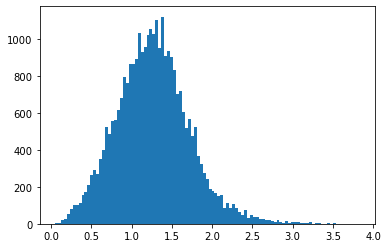

In [25]:
df_daily['entropy_of_durations'] = df_daily['list_of_durations'].map(lambda x: sampen(x))
plt.hist(df_daily[(~df_daily['entropy_of_durations'].isnull())&(df_daily['entropy_of_durations']!=inf)]['entropy_of_durations'],
         bins='auto');

### WG variables

df_daily['in_WG_15mnAfterOpening'] = df_daily['in_WG_15mnAfterOpening'].astype(float)

def WG_open_time(config, x):
    dico_ = config.dico_garden_opening_hour
    #take info (i.e. values) of the dico_ key that represent the smallest date among all the date>=x:
    m = min([d for d in dico_.keys() if d>=dt.datetime(x.year,x.month,x.day,0,0,0)])
    t = dico_[m]
    return (dt.datetime(1999,1,1,t['end_h'],t['end_m'],0) - dt.datetime(1999,1,1,t['start_h'],t['start_m'],0)).total_seconds()

#(Total time outside)/(total time wg is open)
df_daily['time_wg_open_sec'] = df_daily['level'].map(lambda x: WG_open_time(config,x))
df_daily['percentage_time_outside_while_WG_open'] = df_daily.apply(lambda x: x['duration_1_Zone']/x['time_wg_open_sec']*100, axis=1)

In [ ]:
df_daily[df_daily['duration_1_Zone']>0][['level','HenID','time_wg_open_sec','perc_1_Zone_while_WG_open',
                                         'duration_1_Zone']]

### night variables

In [30]:
#Ratio: #transition overnight/#transition during day 
df_daily['24htotaltransition'] = df_daily.apply(lambda x: x['Total_number_transition']+x['night_Total_number_transition'],axis=1)
df_daily['#trnight/#totaltr'] = df_daily.apply(lambda x: x['night_Total_number_transition']/x['24htotaltransition'] if x['24htotaltransition']!=0 else 0, axis=1)
#df_daily[['Total_number_transition','night_Total_number_transition','24htotaltransition','#trnight/#trday']].head(5)
df_daily[(df_daily['#trnight/#totaltr']>=0.25)&(df_daily['24htotaltransition']>=5)][['Total_number_transition','night_Total_number_transition','24htotaltransition','#trnight/#totaltr']].head(5)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Total_number_transition,night_Total_number_transition,24htotaltransition,#trnight/#totaltr
36901,4.0,4.0,8.0,0.500000
5265,4.0,5.0,9.0,0.555556
5286,8.0,4.0,12.0,0.333333
26565,97.0,38.0,135.0,0.281481
16420,34.0,12.0,46.0,0.260870


In [31]:
#“main night zone” equals “main night zone over the last x days”
last_x_days = 5
df_daily['li_night_Max_duration_zones'] = df_daily.apply(lambda x: df_daily[(df_daily['HenID']==x['HenID'])&\
                                                                            (df_daily['level']<x['level'])&\
                                                                            (df_daily['level']>=(x['level']-dt.timedelta(days=last_x_days)))]['night_Max_duration_zones'].tolist(), axis=1)
df_daily['nbr_same_mainnightzone'+str(last_x_days)+'Days'] = df_daily.apply(lambda x: sum([i==x['night_Max_duration_zones'] for i in x['li_night_Max_duration_zones']]), axis=1)
df_daily['nbr_night_'] = df_daily['li_night_Max_duration_zones'].map(lambda x: len(x))
#must be stricty bigger than 3 to start making sense (otherwise we won't be able to know which of the two nights is usual (if any))
df_daily['Consistent_Night_Zone'+str(last_x_days)+'Days'] = df_daily.apply(lambda x: (x['nbr_same_mainnightzone'+str(last_x_days)+'Days']/x['nbr_night_'])>0.65 if x['nbr_night_']>2 else np.nan, axis=1)
df_daily['Consistent_Night_Zone'+str(last_x_days)+'Days'] = df_daily['Consistent_Night_Zone'+str(last_x_days)+'Days'].astype(float) 

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
df_daily[['HenID', 'level', 'night_level', 'li_night_Max_duration_zones', 'night_Max_duration_zones', 
          'night_Total_number_transition','nbr_same_mainnightzone'+str(last_x_days)+'Days','nbr_night_',
          'Consistent_Night_Zone'+str(last_x_days)+'Days']].head(10)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,night_level,li_night_Max_duration_zones,night_Max_duration_zones,night_Total_number_transition,nbr_same_mainnightzone5Days,nbr_night_,Consistent_Night_Zone5Days
36901,hen_1,2020-09-30,2020-09-30_01,[],5_Zone,4.0,0,0,NaN
36902,hen_1,2020-10-01,2020-10-01_02,[5_Zone],5_Zone,0.0,1,1,NaN
36903,hen_1,2020-10-02,2020-10-02_03,"[5_Zone, 5_Zone]",5_Zone,0.0,2,2,NaN
40913,hen_1,2020-10-03,2020-10-03_04,"[5_Zone, 5_Zone, 5_Zone]",5_Zone,0.0,3,3,1.0
40914,hen_1,2020-10-04,2020-10-04_05,"[5_Zone, 5_Zone, 5_Zone, 5_Zone]",5_Zone,0.0,4,4,1.0
40915,hen_1,2020-10-05,2020-10-05_06,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone]",5_Zone,0.0,5,5,1.0
36904,hen_1,2020-10-06,2020-10-06_07,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 5_Zone]",3_Zone,0.0,0,5,0.0
36905,hen_1,2020-10-07,2020-10-07_08,"[5_Zone, 5_Zone, 5_Zone, 5_Zone, 3_Zone]",5_Zone,0.0,4,5,1.0
36906,hen_1,2020-10-10,2020-10-10_11,"[5_Zone, 3_Zone, 5_Zone]",5_Zone,0.0,2,3,1.0
36907,hen_1,2020-10-11,2020-10-11_12,"[3_Zone, 5_Zone, 5_Zone]",5_Zone,0.0,2,3,1.0


### nestbox variables

In [33]:
#turn into categories: "none", <6, <7, <8, <9, <10, <11, <12, "afternoon"
#todo: is of same date?
def class_nestbox_usage(x):
    if issubclass(type(x), type(pd.NaT)):
        return "None"
    elif x.hour<6:
        return "x<6h"
    elif x.hour<=11:
        return str(x.hour)+"h"
    else:
        return "afternoon"
    
df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS'] = df_daily['Nestbox_time_of_first_staid_longer_than900sec'].map(lambda x: class_nestbox_usage(x))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
#Time of first visit longer 15mn - Time of first visit
df_daily['TimeFirstVisitLonger15mn-TimeFirstVisit_mn'] = df_daily.apply(lambda x: round((x['Nestbox_time_of_first_staid_longer_than900sec']-x['FirstTimestamp_4_Zone']).total_seconds()/60,0), axis=1)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
df_daily[~df_daily['Nestbox_time_of_first_staid_longer_than900sec'].isnull()][['Nestbox_time_of_first_staid_longer_than900sec', 
                                                                       'Nestbox_time_of_first_staid_longer_than900sec_CLASS',
                                                                       'HenID', 'level','FirstTimestamp_4_Zone',
                                                                       'TimeFirstVisitLonger15mn-TimeFirstVisit_mn']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Nestbox_time_of_first_staid_longer_than900sec,Nestbox_time_of_first_staid_longer_than900sec_CLASS,HenID,level,FirstTimestamp_4_Zone,TimeFirstVisitLonger15mn-TimeFirstVisit_mn
36901,2020-09-30 16:51:25,afternoon,hen_1,2020-09-30,2020-09-30 16:51:25,0.0
36904,2020-10-06 15:07:25,afternoon,hen_1,2020-10-06,2020-10-06 15:07:25,0.0
36908,2020-10-12 08:42:15,8h,hen_1,2020-10-12,2020-10-12 08:42:15,0.0


In [36]:
#into dummies of interest
display(df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS'].value_counts())
df_daily['Nestbox1staylonger900_None'] = df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS'].map(lambda x: x=='None')
df_daily['Nestbox1staylonger900_Afternoon'] = df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS'].map(lambda x: x=='afternoon')
df_daily['Nestbox1staylonger900_b8'] = df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS'].map(lambda x: x in ['x<6h', '7h'])
df_daily['Nestbox1staylonger900_8-9'] = df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS'].map(lambda x: x=='8h')
df_daily['Nestbox1staylonger900_9-10'] = df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS'].map(lambda x: x=='9h')
df_daily['Nestbox1staylonger900_10-12'] = df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS'].map(lambda x: x in ['10h','11h'])

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


x<6h         25567
None         13132
6h            1111
afternoon      847
7h             442
9h             331
8h             330
10h            208
11h            135
Name: Nestbox_time_of_first_staid_longer_than900sec_CLASS, dtype: int64

In [37]:
df_daily[df_daily['Nestbox_time_of_first_staid_longer_than900sec_CLASS']=='8h'][['Nestbox_time_of_first_staid_longer_than900sec_CLASS','Nestbox1staylonger900_None','Nestbox1staylonger900_Afternoon',
         'Nestbox1staylonger900_b8','Nestbox1staylonger900_8-9','Nestbox1staylonger900_9-10','Nestbox1staylonger900_10-12']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Nestbox_time_of_first_staid_longer_than900sec_CLASS,Nestbox1staylonger900_None,Nestbox1staylonger900_Afternoon,Nestbox1staylonger900_b8,Nestbox1staylonger900_8-9,Nestbox1staylonger900_9-10,Nestbox1staylonger900_10-12
36908,8h,False,False,False,True,False,False
5276,8h,False,False,False,True,False,False
5301,8h,False,False,False,True,False,False


In [38]:
#percentage of visits in afternon versus visits in the morning  (#visits after 12h) / (total number of visits)*100
#TODO: verify it
df_daily['Nestbox_perc_of_visits_afternoon_vs_morning&afternoon'] = df_daily.apply(lambda x: x['A12h_Nestbox_nbrvisit']/x['nbr_stays_4_Zone']*100 if x['nbr_stays_4_Zone']!=0 else 0,
                                                                                 axis=1)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### max duration zone into dummies of interest

In [39]:
display(df_daily['Max_duration_zones'].value_counts())
df_daily['is_max_zone_duration_zone1'] = df_daily['Max_duration_zones'].map(lambda x: x=='1_Zone')
df_daily['is_max_zone_duration_zone2'] = df_daily['Max_duration_zones'].map(lambda x: x=='2_Zone')
df_daily['is_max_zone_duration_zone3'] = df_daily['Max_duration_zones'].map(lambda x: x=='3_Zone')
df_daily['is_max_zone_duration_zone4'] = df_daily['Max_duration_zones'].map(lambda x: x=='4_Zone')
df_daily['is_max_zone_duration_zone5'] = df_daily['Max_duration_zones'].map(lambda x: x=='5_Zone')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5_Zone                  18651
2_Zone                   7098
4_Zone                   4781
3_Zone                   1211
1_Zone                     85
['4_Zone', '2_Zone']        3
['2_Zone', '5_Zone']        1
['5_Zone', '4_Zone']        1
Name: Max_duration_zones, dtype: int64

In [40]:
#night max duration zone
display(df_daily['night_Max_duration_zones'].value_counts())#not zone 1 as cant sleep outside :)
df_daily['is_max_nightzone_duration_zone2'] = df_daily['night_Max_duration_zones'].map(lambda x: x=='2_Zone')
df_daily['is_max_nightzone_duration_zone3'] = df_daily['night_Max_duration_zones'].map(lambda x: x=='3_Zone')
df_daily['is_max_nightzone_duration_zone4'] = df_daily['night_Max_duration_zones'].map(lambda x: x=='4_Zone')
df_daily['is_max_nightzone_duration_zone5'] = df_daily['night_Max_duration_zones'].map(lambda x: x=='5_Zone')
df_daily['is_max_nightzone_duration_zonelitterORlowerperch'] = df_daily.apply(lambda x: (x['is_max_nightzone_duration_zone2']==1)|\
                                                                              (x['is_max_nightzone_duration_zone3']==1), axis=1)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5_Zone    29637
3_Zone     6270
4_Zone     4722
2_Zone     1042
Name: night_Max_duration_zones, dtype: int64

In [41]:
df_daily[['night_Max_duration_zones','is_max_nightzone_duration_zone3','is_max_nightzone_duration_zone5']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,night_Max_duration_zones,is_max_nightzone_duration_zone3,is_max_nightzone_duration_zone5
36901,5_Zone,False,True
36902,5_Zone,False,True
36903,5_Zone,False,True


In [42]:
li_2keep = ['HenID','level']
#display(list(df_daily.columns))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Clustering general activity 

In [43]:
#list(df_daily.columns)
df_daily.shape

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42103, 205)

In [44]:
#dividing into list for plot
li_dur = ['perc_duration_1_Zone', 'perc_duration_2_Zone', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone']
li_tr = ['nbr_stays_3_Zone','nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'nbr_stays_2_Zone', 'nbr_stays_1_Zone']
li_missingtzone = ['down_missingZone_mvtPerc', 'up_missingZone_mvtPerc']
li_chaotic = ['chaoticmvt_Middle1_Zone_nbr_180mn', 'chaoticmvt_Middle2_Zone_nbr_180mn', 'chaoticmvt_Middle3_Zone_nbr_180mn', 
              'chaoticmvt_Middle4_Zone_nbr_180mn']
li_activity = ['activity_25percentile_sec', 'activity_50percentile_sec', 'activity_5percentile_sec','activity_95percentile_sec']
li_maxzone = ['is_max_zone_duration_zone1','is_max_zone_duration_zone2','is_max_zone_duration_zone3',
                       'is_max_zone_duration_zone4', 'is_max_zone_duration_zone5']
li_maxnightzone = ['is_max_nightzone_duration_zone2',  'is_max_nightzone_duration_zone3', 
                   'is_max_nightzone_duration_zone4', 'is_max_nightzone_duration_zone5']
li_gali = [li_dur, li_tr, li_missingtzone, li_chaotic, li_activity, li_maxzone, li_maxnightzone]
li_general_activity = ['variance_duration', 'median_duration', 'max_duration','Total_number_zone','#trnight/#totaltr',
                       'vertical_travel_distance','duration_last-firsttransition_mn', 'night_Total_number_transition',
                       'Consistent_Night_Zone'+str(last_x_days)+'Days']
for li_ in li_gali:
    li_general_activity = li_general_activity+li_
df_daily[li_2keep+li_general_activity].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,variance_duration,median_duration,max_duration,Total_number_zone,#trnight/#totaltr,vertical_travel_distance,duration_last-firsttransition_mn,night_Total_number_transition,...,activity_95percentile_sec,is_max_zone_duration_zone1,is_max_zone_duration_zone2,is_max_zone_duration_zone3,is_max_zone_duration_zone4,is_max_zone_duration_zone5,is_max_nightzone_duration_zone2,is_max_nightzone_duration_zone3,is_max_nightzone_duration_zone4,is_max_nightzone_duration_zone5
36901,hen_1,2020-09-30,4.745953e+07,3359.0,18886.0,4.0,0.5,7.0,415.0,4.0,...,60556.0,False,True,False,False,False,False,False,False,True
36902,hen_1,2020-10-01,1.388373e+07,1321.0,15030.0,3.0,0.0,18.0,284.0,0.0,...,49433.0,False,False,False,False,True,False,False,False,True
36903,hen_1,2020-10-02,7.229724e+07,10478.0,21371.0,2.0,0.0,4.0,9.0,0.0,...,42878.0,False,False,False,False,True,False,False,False,True


In [45]:
df_ = df_daily[li_general_activity+li_2keep].dropna(how='any').copy()

#scaling data
df_kmeans = df_.copy()
sc = StandardScaler()
df_kmeans[li_general_activity] = sc.fit_transform(df_kmeans[li_general_activity])
display(df_kmeans[li_general_activity].head(3))

print(df_daily.shape, df_kmeans.shape)
li_ = range(2,10)
r, center_ = kmeans_clustering(df=df_kmeans, range_n_clusters=li_, drop_col_list=li_2keep)
if len(r)!=df_kmeans.shape[0]:
    print('ERROR')
    sys.exit()
df_['clustering_general_activity'] = r
display(df_[li_2keep+li_general_activity+['clustering_general_activity']].head(3))
print(df_daily.shape)
df_daily = pd.merge(df_daily, df_[li_2keep+['clustering_general_activity']], on=['HenID','level'], how='left')
print(df_daily.shape)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,variance_duration,median_duration,max_duration,Total_number_zone,#trnight/#totaltr,vertical_travel_distance,duration_last-firsttransition_mn,night_Total_number_transition,Consistent_Night_Zone5Days,duration_1_Zone,...,activity_95percentile_sec,is_max_zone_duration_zone1,is_max_zone_duration_zone2,is_max_zone_duration_zone3,is_max_zone_duration_zone4,is_max_zone_duration_zone5,is_max_nightzone_duration_zone2,is_max_nightzone_duration_zone3,is_max_nightzone_duration_zone4,is_max_nightzone_duration_zone5
36904,0.513752,4.476950,0.615886,-0.983410,-0.268313,-1.891178,-2.882437,-0.26681,-1.414038,-0.602243,...,-0.296700,-0.051919,-0.539008,-0.201445,-0.427033,0.853075,-0.066838,2.260054,-0.374329,-1.560633
36905,6.214515,0.227695,3.072038,-2.693368,-0.268313,-2.107002,-4.829714,-0.26681,0.707195,-0.602243,...,-4.109757,-0.051919,-0.539008,-0.201445,-0.427033,0.853075,-0.066838,-0.442467,-0.374329,0.640766
36908,2.334576,0.265358,2.892419,-0.983410,-0.268313,-1.747294,-1.278430,-0.26681,0.707195,-0.602243,...,1.030752,-0.051919,-0.539008,-0.201445,-0.427033,0.853075,-0.066838,-0.442467,-0.374329,0.640766


(42103, 205) (30130, 40)
For n_clusters = 2 The average silhouette_score is : 0.15754530903399533
For n_clusters = 3 The average silhouette_score is : 0.14044702663106706
For n_clusters = 4 The average silhouette_score is : 0.1298799940729521
For n_clusters = 5 The average silhouette_score is : 0.09630237734333053
For n_clusters = 6 The average silhouette_score is : 0.10528218575426683
For n_clusters = 7 The average silhouette_score is : 0.1101148797142197
For n_clusters = 8 The average silhouette_score is : 0.09290109029386412
For n_clusters = 9 The average silhouette_score is : 0.08759006342762708
Please let me know the numbers of clusters you want to search for 7
(30130, 38)


,HenID,level,variance_duration,median_duration,max_duration,Total_number_zone,#trnight/#totaltr,vertical_travel_distance,duration_last-firsttransition_mn,night_Total_number_transition,...,is_max_zone_duration_zone1,is_max_zone_duration_zone2,is_max_zone_duration_zone3,is_max_zone_duration_zone4,is_max_zone_duration_zone5,is_max_nightzone_duration_zone2,is_max_nightzone_duration_zone3,is_max_nightzone_duration_zone4,is_max_nightzone_duration_zone5,clustering_general_activity
36904,hen_1,2020-10-06,2.551760e+07,4608.0,13301.0,4.0,0.0,8.0,316.0,0.0,...,False,False,False,False,True,False,True,False,False,5
36905,hen_1,2020-10-07,2.120631e+08,772.0,31392.0,3.0,0.0,2.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,3
36908,hen_1,2020-10-12,8.510026e+07,806.0,30069.0,4.0,0.0,12.0,573.0,0.0,...,False,False,False,False,True,False,False,False,True,5


(42103, 205)
(42103, 206)


In [46]:
#### one table with mean for each variable within each clusters
li_df = []#
for k in df_['clustering_general_activity'].unique():
    df0 = df_[df_['clustering_general_activity']==k][li_general_activity]
    li_df.append(df0.mean())
df_m = pd.concat(li_df,axis=1)
df_m.to_csv(os.path.join(path_cluster, 'GeneralActivity_clusters_properties.csv'))
print(df_m.shape)
df_m

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(37, 7)


,0,1,2,3,4,5,6
variance_duration,1.792189e+07,1.662821e+08,2.429820e+06,977863.189746,1.491460e+06,1.041521e+06,582204.424145
median_duration,6.128025e+02,3.719759e+03,3.444767e+02,572.605022,5.402380e+02,4.574444e+02,264.210913
max_duration,1.640688e+04,3.438275e+04,8.492791e+03,4848.559453,5.734903e+03,4.645457e+03,4613.829830
Total_number_zone,4.316278e+00,3.258503e+00,4.847473e+00,4.650325,4.458528e+00,4.975309e+00,4.820616
#trnight/#totaltr,5.652446e-03,2.430900e-02,3.958644e-03,0.003032,2.536182e-02,1.013745e-02,0.004136
vertical_travel_distance,3.032489e+01,7.131973e+00,6.297333e+01,64.359771,6.350552e+01,5.612346e+01,105.896919
night_Total_number_transition,1.577170e-01,1.537415e-01,2.520274e-01,0.195430,1.742140e+00,7.283951e-01,0.454938
Consistent_Night_Zone5Days,8.434650e-01,8.517007e-01,7.128821e-01,0.751561,3.429766e-01,4.320988e-01,0.619061
duration_1_Zone,3.250253e+02,0.000000e+00,1.903767e+03,958.165006,8.709214e+02,9.592593e+03,1251.723006
duration_2_Zone,9.084802e+03,2.011434e+03,1.583130e+04,26961.155706,2.648173e+04,1.971219e+04,23774.105096


In [47]:
df_daily[df_daily['duration_last-firsttransition_mn'].isnull()]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,is_max_zone_duration_zone2,is_max_zone_duration_zone3,is_max_zone_duration_zone4,is_max_zone_duration_zone5,is_max_nightzone_duration_zone2,is_max_nightzone_duration_zone3,is_max_nightzone_duration_zone4,is_max_nightzone_duration_zone5,is_max_nightzone_duration_zonelitterORlowerperch,clustering_general_activity
3,hen_1,2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN
4,hen_1,2020-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN
5,hen_1,2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN
80,hen_1,2020-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN
113,hen_1,2021-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42004,hen_99,2021-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN
42005,hen_99,2021-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN
42006,hen_99,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN
42062,hen_99,2021-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[nan, nan, nan, nan, nan]",...,False,False,False,False,False,False,False,True,False,NaN


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


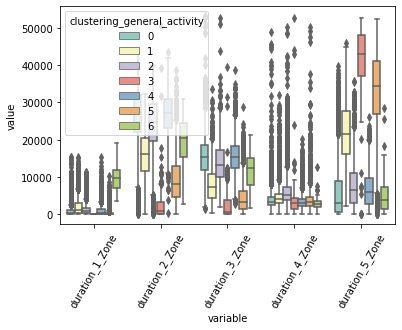

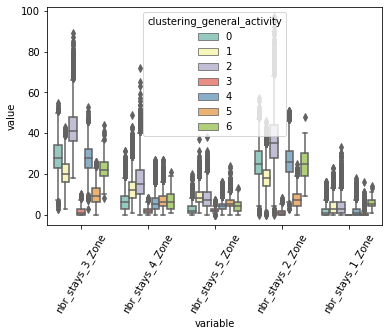

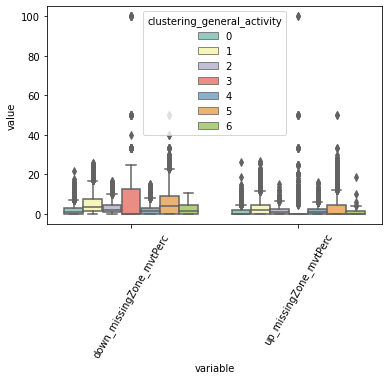

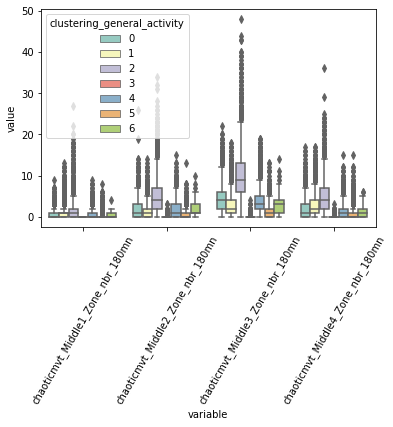

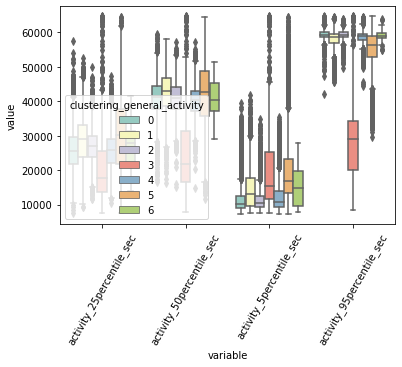

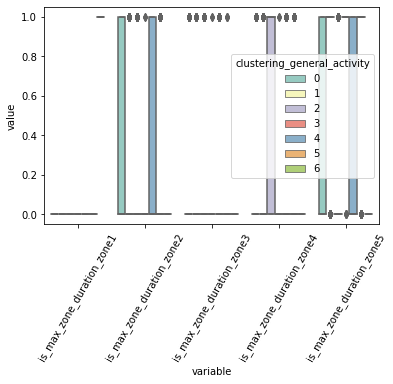

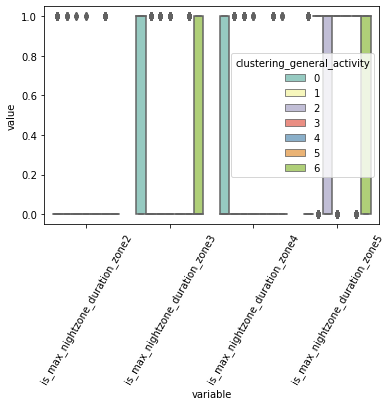

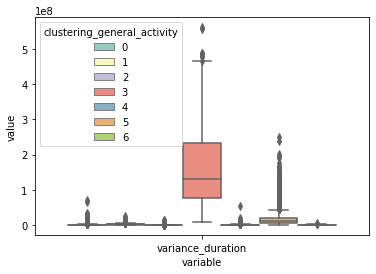

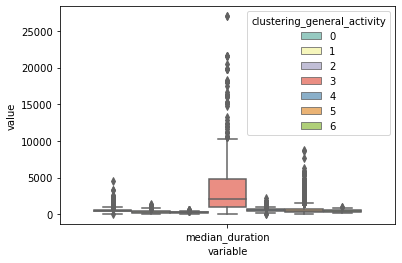

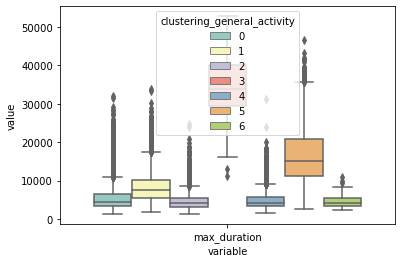

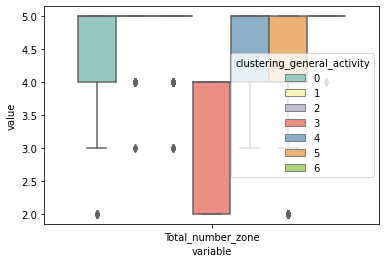

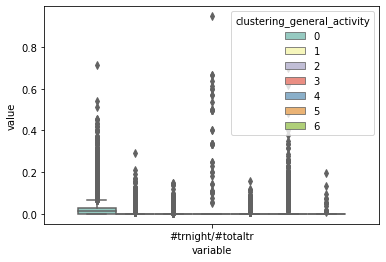

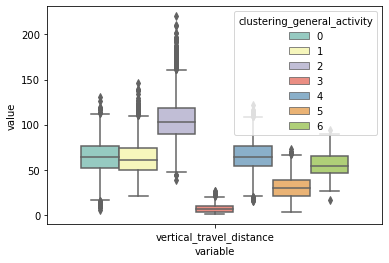

ERROR:  duration_last-firsttransition_mn   Neither the `x` nor `y` variable appears to be numeric.


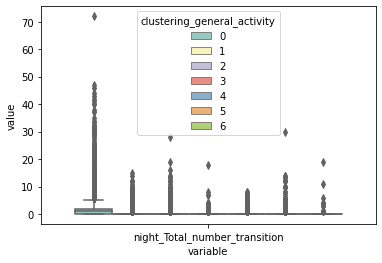

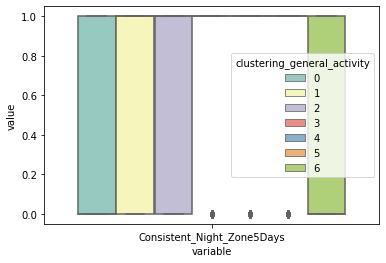

In [48]:
#### plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
nbr = 0
for li_ in li_gali:
    #display(df_[['clustering_coeff','HenID','level']+li_gali[0]].head(3))
    df_plt = pd.melt(df_, id_vars=['clustering_general_activity','HenID','level'], value_vars=li_).reset_index(drop=True)
    #print(df_plt.shape)
    #display(df_plt.head(3))
    ax = sns.boxplot(x="variable", y="value", hue="clustering_general_activity",data=df_plt, palette="Set3")
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=60)
    plt.savefig(os.path.join(path_cluster,'GeneralActivity_'+str(nbr)+'.png'), bbox_inches='tight')
    nbr = nbr+1
    plt.show();
for x in li_general_activity:
    if not any([any([x in li]) for li in li_gali]):
        try:
            df_plt = pd.melt(df_, id_vars=['clustering_general_activity','HenID','level'], value_vars=x).reset_index(drop=True)
            #display(df_plt.head(3))
            ax = sns.boxplot(x="variable", y="value", hue="clustering_general_activity",data=df_plt, palette="Set3")
            plt.savefig(os.path.join(path_cluster,'GeneralActivity_'+x.replace('/','')+'.png'), bbox_inches='tight')
            plt.show();
        except Exception as e:
            print('ERROR: ',x, ' ',e)

# Clustering nestbox

In [49]:
li_staylonger900 = ['Nestbox1staylonger900_None', 'Nestbox1staylonger900_Afternoon', 'Nestbox1staylonger900_b8',
                    'Nestbox1staylonger900_8-9', 'Nestbox1staylonger900_9-10', 'Nestbox1staylonger900_10-12']
li_nestbox_usage = ['sucessIntrusion_9','TimeFirstVisitLonger15mn-TimeFirstVisit_mn','B10h_Nestbox_nbrvisit', 
                    'B10h_Nestbox_Longestduration', 'A12h_Nestbox_nbrvisit', 'A12h_Nestbox_Longestduration']
li_nb = [li_staylonger900]
for li_ in li_nb:
    li_nestbox_usage = li_nestbox_usage+li_
df_daily[li_2keep+li_nestbox_usage].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,sucessIntrusion_9,TimeFirstVisitLonger15mn-TimeFirstVisit_mn,B10h_Nestbox_nbrvisit,B10h_Nestbox_Longestduration,A12h_Nestbox_nbrvisit,A12h_Nestbox_Longestduration,Nestbox1staylonger900_None,Nestbox1staylonger900_Afternoon,Nestbox1staylonger900_b8,Nestbox1staylonger900_8-9,Nestbox1staylonger900_9-10,Nestbox1staylonger900_10-12
0,hen_1,2020-09-30,0.0,0.0,0.0,0.0,1.0,58426.0,False,True,False,False,False,False
1,hen_1,2020-10-01,0.0,NaN,0.0,0.0,0.0,0.0,True,False,False,False,False,False
2,hen_1,2020-10-02,0.0,NaN,0.0,0.0,0.0,0.0,True,False,False,False,False,False


In [50]:
df_daily[df_daily['sucessIntrusion_9']<=0.4][li_2keep+['PenID']+li_nestbox_usage].tail(5)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,PenID,sucessIntrusion_9,TimeFirstVisitLonger15mn-TimeFirstVisit_mn,B10h_Nestbox_nbrvisit,B10h_Nestbox_Longestduration,A12h_Nestbox_nbrvisit,A12h_Nestbox_Longestduration,Nestbox1staylonger900_None,Nestbox1staylonger900_Afternoon,Nestbox1staylonger900_b8,Nestbox1staylonger900_8-9,Nestbox1staylonger900_9-10,Nestbox1staylonger900_10-12
42098,hen_99,2021-05-05,11,0.333333,125.0,5.0,3729.0,2.0,58.0,False,False,True,False,False,False
42099,hen_99,2021-05-06,11,0.200000,90.0,6.0,4258.0,4.0,155.0,False,False,True,False,False,False
42100,hen_99,2021-05-07,11,0.200000,102.0,5.0,4870.0,1.0,49.0,False,False,True,False,False,False
42101,hen_99,2021-05-08,11,0.166667,122.0,7.0,3752.0,1.0,11.0,False,False,True,False,False,False
42102,hen_99,2021-05-09,11,0.200000,131.0,6.0,4227.0,1.0,11.0,False,False,True,False,False,False


In [51]:
df_ = df_daily[li_nestbox_usage+li_2keep].dropna(how='any').copy()

#scaling data
df_kmeans = df_.copy()
sc = StandardScaler()
df_kmeans[li_nestbox_usage] = sc.fit_transform(df_kmeans[li_nestbox_usage])
display(df_kmeans[li_nestbox_usage].head(3))

print(df_daily.shape, df_kmeans.shape)
li_ = range(2,8)
r, center_ = kmeans_clustering(df=df_kmeans, range_n_clusters=li_, drop_col_list=li_2keep)
if len(r)!=df_kmeans.shape[0]:
    print('ERROR')
    sys.exit()
df_['clustering_nestbox'] = r
display(df_[li_2keep+li_nestbox_usage+['clustering_nestbox']].head(3))
print(df_daily.shape)
df_daily = pd.merge(df_daily, df_[li_2keep+['clustering_nestbox']], on=['HenID','level'], how='left')
print(df_daily.shape)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sucessIntrusion_9,TimeFirstVisitLonger15mn-TimeFirstVisit_mn,B10h_Nestbox_nbrvisit,B10h_Nestbox_Longestduration,A12h_Nestbox_nbrvisit,A12h_Nestbox_Longestduration,Nestbox1staylonger900_None,Nestbox1staylonger900_Afternoon,Nestbox1staylonger900_b8,Nestbox1staylonger900_8-9,Nestbox1staylonger900_9-10,Nestbox1staylonger900_10-12
0,-1.347556,-0.615232,-1.344157,-1.612786,-0.670079,4.999700,0.0,5.762210,-2.9632,-0.107342,-0.107507,-0.109461
6,-1.347556,-0.615232,-1.344157,-1.612786,-0.670079,-0.240479,0.0,5.762210,-2.9632,-0.107342,-0.107507,-0.109461
10,2.093354,-0.615232,-1.047458,-1.113968,-0.670079,-0.278135,0.0,-0.173545,-2.9632,9.316001,-0.107507,-0.109461


(42103, 206) (28970, 14)
For n_clusters = 2 The average silhouette_score is : 0.6534550814872743
For n_clusters = 3 The average silhouette_score is : 0.6619765450351323
For n_clusters = 4 The average silhouette_score is : 0.23768526997654346
For n_clusters = 5 The average silhouette_score is : 0.24901339538417902
For n_clusters = 6 The average silhouette_score is : 0.2577342200478779
For n_clusters = 7 The average silhouette_score is : 0.2682503018693639
Please let me know the numbers of clusters you want to search for 3
(28970, 12)


,HenID,level,sucessIntrusion_9,TimeFirstVisitLonger15mn-TimeFirstVisit_mn,B10h_Nestbox_nbrvisit,B10h_Nestbox_Longestduration,A12h_Nestbox_nbrvisit,A12h_Nestbox_Longestduration,Nestbox1staylonger900_None,Nestbox1staylonger900_Afternoon,Nestbox1staylonger900_b8,Nestbox1staylonger900_8-9,Nestbox1staylonger900_9-10,Nestbox1staylonger900_10-12,clustering_nestbox
0,hen_1,2020-09-30,0.0,0.0,0.0,0.0,1.0,58426.0,False,True,False,False,False,False,2
6,hen_1,2020-10-06,0.0,0.0,0.0,0.0,1.0,1092.0,False,True,False,False,False,False,2
10,hen_1,2020-10-12,1.0,0.0,1.0,911.0,1.0,680.0,False,False,False,True,False,False,1


(42103, 206)
(42103, 207)


In [52]:
#### one table with mean for each variable within each clusters
li_df = []
for k in df_['clustering_nestbox'].unique():
    df0 = df_[df_['clustering_nestbox']==k][li_nestbox_usage]
    li_df.append(df0.mean())
df_m = pd.concat(li_df,axis=1)
df_m.to_csv(os.path.join(path_cluster, 'NestBox_clusters_properties.csv'))
print(df_m.shape)
df_m.head

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(12, 3)


<bound method NDFrame.head of                                                        0            1  \
sucessIntrusion_9                               0.000000     0.132153   
TimeFirstVisitLonger15mn-TimeFirstVisit_mn    350.809917   122.163347   
B10h_Nestbox_nbrvisit                           2.207792     4.384462   
B10h_Nestbox_Longestduration                  205.284534  1690.201195   
A12h_Nestbox_nbrvisit                           5.874852     5.198207   
A12h_Nestbox_Longestduration                16364.394333  6864.336653   
Nestbox1staylonger900_None                      0.000000     0.000000   
Nestbox1staylonger900_Afternoon                 1.000000     0.000000   
Nestbox1staylonger900_b8                        0.000000     0.000000   
Nestbox1staylonger900_8-9                       0.000000     0.328685   
Nestbox1staylonger900_9-10                      0.000000     0.329681   
Nestbox1staylonger900_10-12                     0.000000     0.341633   

                    

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


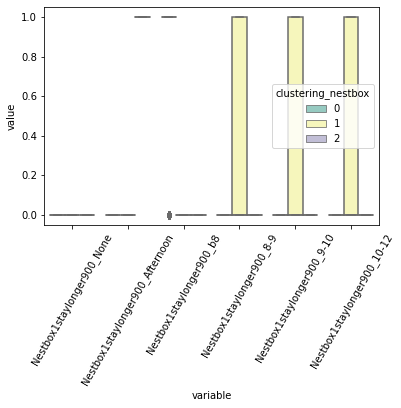

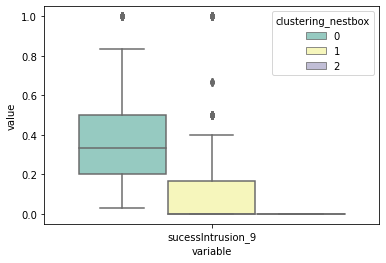

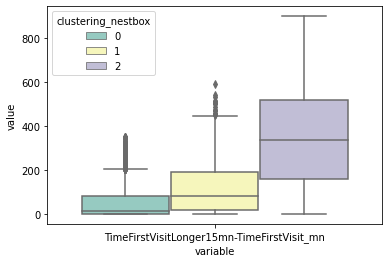

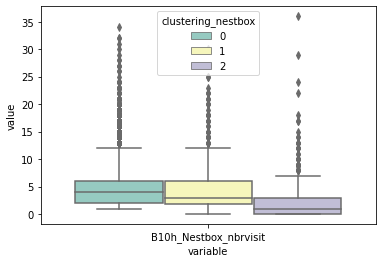

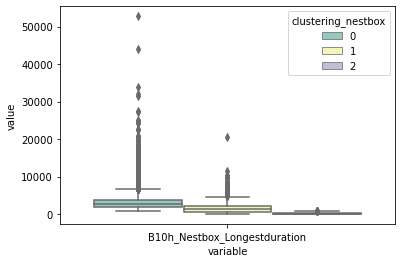

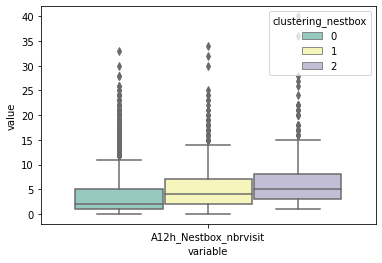

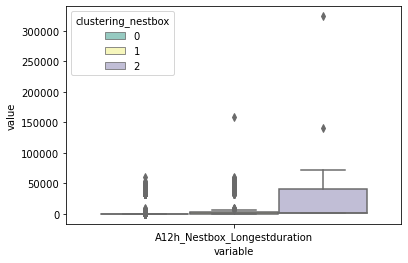

In [53]:
#### plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
nbr = 0
for li_ in li_nb:
    #display(df_[['clustering_coeff','HenID','level']+li_gali[0]].head(3))
    df_plt = pd.melt(df_, id_vars=['clustering_nestbox','HenID','level'], value_vars=li_).reset_index(drop=True)
    #print(df_plt.shape)
    #display(df_plt.head(3))
    ax = sns.boxplot(x="variable", y="value", hue="clustering_nestbox",data=df_plt, palette="Set3")
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=60)
    plt.savefig(os.path.join(path_cluster,'NestBox_'+str(nbr)+'.png'), bbox_inches='tight')
    nbr = nbr+1
    plt.show();
for x in li_nestbox_usage:
    if not any([any([x in li]) for li in li_nb]):
        df_plt = pd.melt(df_, id_vars=['clustering_nestbox','HenID','level'], value_vars=x).reset_index(drop=True)
        #display(df_plt.head(3))
        ax = sns.boxplot(x="variable", y="value", hue="clustering_nestbox",data=df_plt, palette="Set3")
        plt.savefig(os.path.join(path_cluster,'NestBox_'+x+'.png'), bbox_inches='tight')
        plt.show();

# Clustering WG

In [54]:
li_WG_usage = ['nbr_stays_1_Zone', 'in_WG_15mnAfterOpening', 'Max_duration_WG', 'duration_1_Zone']
df_daily[li_2keep+li_WG_usage].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,nbr_stays_1_Zone,in_WG_15mnAfterOpening,Max_duration_WG,duration_1_Zone
0,hen_1,2020-09-30,0.0,0.0,0.0,0.0
1,hen_1,2020-10-01,0.0,0.0,0.0,0.0
2,hen_1,2020-10-02,0.0,0.0,0.0,0.0


In [55]:
df_ = df_daily[li_WG_usage+li_2keep].dropna(how='any').copy()

#scaling data
df_kmeans = df_.copy()
sc = StandardScaler()
df_kmeans[li_WG_usage] = sc.fit_transform(df_kmeans[li_WG_usage])
display(df_kmeans[li_WG_usage].head(3))

print(df_daily.shape, df_kmeans.shape)
li_ = range(2,8)
r, center_ = kmeans_clustering(df=df_kmeans, range_n_clusters=li_, drop_col_list=li_2keep)
if len(r)!=df_kmeans.shape[0]:
    print('ERROR')
    sys.exit()
df_['clustering_WG'] = r
display(df_[li_2keep+li_WG_usage+['clustering_WG']].head(3))
print(df_daily.shape)
df_daily = pd.merge(df_daily, df_[li_2keep+['clustering_WG']], on=['HenID','level'], how='left')
print(df_daily.shape)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,nbr_stays_1_Zone,in_WG_15mnAfterOpening,Max_duration_WG,duration_1_Zone
0,-0.743693,-0.465548,-0.65644,-0.588578
1,-0.743693,-0.465548,-0.65644,-0.588578
2,-0.743693,-0.465548,-0.65644,-0.588578


(42103, 207) (31831, 6)
For n_clusters = 2 The average silhouette_score is : 0.6014020189080479
For n_clusters = 3 The average silhouette_score is : 0.6290797762448748
For n_clusters = 4 The average silhouette_score is : 0.6132347451536151
For n_clusters = 5 The average silhouette_score is : 0.6131671839039103
For n_clusters = 6 The average silhouette_score is : 0.5895868336005926
For n_clusters = 7 The average silhouette_score is : 0.5910588541410144
Please let me know the numbers of clusters you want to search for 3
(31831, 4)


,HenID,level,nbr_stays_1_Zone,in_WG_15mnAfterOpening,Max_duration_WG,duration_1_Zone,clustering_WG
0,hen_1,2020-09-30,0.0,0.0,0.0,0.0,1
1,hen_1,2020-10-01,0.0,0.0,0.0,0.0,1
2,hen_1,2020-10-02,0.0,0.0,0.0,0.0,1


(42103, 207)
(42103, 208)


In [56]:
#### one table with mean for each variable within each clusters
li_df = []
for k in df_['clustering_WG'].unique():
    df0 = df_[df_['clustering_WG']==k][li_WG_usage]
    li_df.append(df0.mean())
df_m = pd.concat(li_df,axis=1)
df_m.to_csv(os.path.join(path_cluster, 'WinterGarten_clusters_properties.csv'))
print(df_m.shape)
df_m

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(4, 3)


,0,1,2
nbr_stays_1_Zone,1.191770,7.681973,3.583495
in_WG_15mnAfterOpening,0.000000,0.403569,1.000000
Max_duration_WG,215.960399,1640.047494,593.695063
duration_1_Zone,375.211403,4806.554710,1282.370765


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


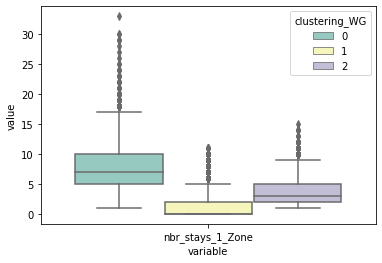

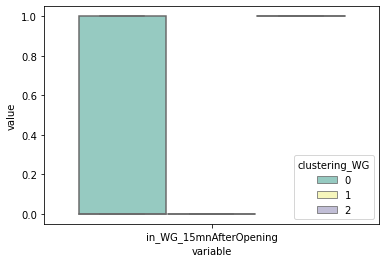

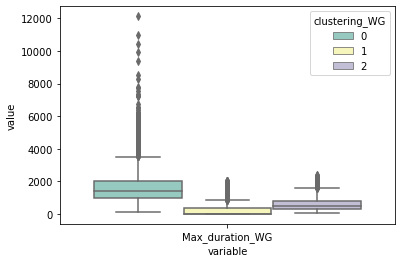

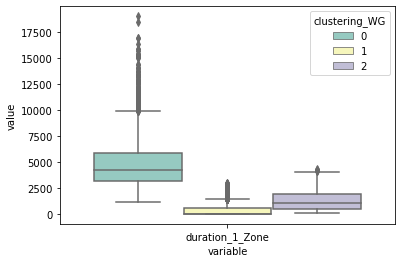

In [57]:
#### plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
for x in li_WG_usage:
    df_plt = pd.melt(df_, id_vars=['clustering_WG','HenID','level'], value_vars=x).reset_index(drop=True)
    ax = sns.boxplot(x="variable", y="value", hue="clustering_WG",data=df_plt, palette="Set3")
    plt.savefig(os.path.join(path_cluster,'WinterGarten_'+x+'.png'), bbox_inches='tight')
    plt.show();

In [58]:
df_daily[df_daily['duration_1_Zone']>30000]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,is_max_zone_duration_zone4,is_max_zone_duration_zone5,is_max_nightzone_duration_zone2,is_max_nightzone_duration_zone3,is_max_nightzone_duration_zone4,is_max_nightzone_duration_zone5,is_max_nightzone_duration_zonelitterORlowerperch,clustering_general_activity,clustering_nestbox,clustering_WG


### clustering accelerometer

li_accelerometer = ['MovementCounter_median', 'MovementCounter_max', 'MovementCounter_sum',
                    'temperature_max', 'temperature_median']
df_daily[['HenID','level']+li_accelerometer].head(3)

df_ = df_daily[li_accelerometer+li_2keep].dropna(how='any')
print(df_daily.shape, df_.shape)
li_ = range(2,8)
r, center_ = kmeans_clustering(df=df_, range_n_clusters=li_, drop_col_list=li_2keep)
df_['clustering_coeff'] = r
df_.head(3)

# Clustering all

In [59]:
li_all = li_general_activity+li_WG_usage #to much nan for now: li_nestbox_usage
df_daily[li_2keep+li_all].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,variance_duration,median_duration,max_duration,Total_number_zone,#trnight/#totaltr,vertical_travel_distance,duration_last-firsttransition_mn,night_Total_number_transition,...,is_max_zone_duration_zone4,is_max_zone_duration_zone5,is_max_nightzone_duration_zone2,is_max_nightzone_duration_zone3,is_max_nightzone_duration_zone4,is_max_nightzone_duration_zone5,nbr_stays_1_Zone,in_WG_15mnAfterOpening,Max_duration_WG,duration_1_Zone
0,hen_1,2020-09-30,4.745953e+07,3359.0,18886.0,4.0,0.5,7.0,415.0,4.0,...,False,False,False,False,False,True,0.0,0.0,0.0,0.0
1,hen_1,2020-10-01,1.388373e+07,1321.0,15030.0,3.0,0.0,18.0,284.0,0.0,...,False,True,False,False,False,True,0.0,0.0,0.0,0.0
2,hen_1,2020-10-02,7.229724e+07,10478.0,21371.0,2.0,0.0,4.0,9.0,0.0,...,False,True,False,False,False,True,0.0,0.0,0.0,0.0


In [60]:
df_ = df_daily[list(set(li_all+li_2keep))].dropna(how='any').copy()
df_pca = df_.copy()
print(df_daily.shape, df_pca.shape)

#scaling numerical data: necessary due to duration high values
sc = StandardScaler()
df_pca[li_all] = sc.fit_transform(df_pca[li_all])
display(df_pca[li_all].head(3))

#fix random seed in order to have always the same plots 
np.random.seed(0)

######### PCA
#initialise model
X = df_pca[li_all].values
pca = decomposition.PCA(n_components=8, svd_solver='full') #arpack #len(li_all)-1
#fit model to data
pca.fit(X)
#Apply dimensionality reduction to X.
X = pca.transform(X)
print(X.shape)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(42103, 208) (30130, 42)


,variance_duration,median_duration,max_duration,Total_number_zone,#trnight/#totaltr,vertical_travel_distance,duration_last-firsttransition_mn,night_Total_number_transition,Consistent_Night_Zone5Days,duration_1_Zone,...,is_max_zone_duration_zone4,is_max_zone_duration_zone5,is_max_nightzone_duration_zone2,is_max_nightzone_duration_zone3,is_max_nightzone_duration_zone4,is_max_nightzone_duration_zone5,nbr_stays_1_Zone,in_WG_15mnAfterOpening,Max_duration_WG,duration_1_Zone
6,0.513752,4.476950,0.615886,-0.983410,-0.268313,-1.891178,-2.882437,-0.26681,-1.414038,-0.602243,...,-0.427033,0.853075,-0.066838,2.260054,-0.374329,-1.560633,-0.76146,-0.473865,-0.677454,-0.602243
7,6.214515,0.227695,3.072038,-2.693368,-0.268313,-2.107002,-4.829714,-0.26681,0.707195,-0.602243,...,-0.427033,0.853075,-0.066838,-0.442467,-0.374329,0.640766,-0.76146,-0.473865,-0.677454,-0.602243
10,2.334576,0.265358,2.892419,-0.983410,-0.268313,-1.747294,-1.278430,-0.26681,0.707195,-0.602243,...,-0.427033,0.853075,-0.066838,-0.442467,-0.374329,0.640766,-0.76146,-0.473865,-0.677454,-0.602243


(30130, 8)


In [61]:
#add each princiapl component to the initial (i.e. without scaling) dataframe
df_comp = pd.DataFrame(X)
print(df_.shape, df_comp.shape)
li_pca = []
for i in range(0, pca.n_components_):
    df_['PC'+str(i)] = df_comp[i].tolist()
    li_pca.append('PC'+str(i))
df_.head(3)

(30130, 42) (30130, 8)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,nbr_stays_2_Zone,chaoticmvt_Middle4_Zone_nbr_180mn,Max_duration_WG,chaoticmvt_Middle2_Zone_nbr_180mn,duration_last-firsttransition_mn,chaoticmvt_Middle1_Zone_nbr_180mn,vertical_travel_distance,max_duration,up_missingZone_mvtPerc,duration_3_Zone,...,Total_number_zone,activity_95percentile_sec,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7
6,1.0,0.0,0.0,0.0,316.0,0.0,8.0,13301.0,0.0,742.0,...,4.0,55537.0,6.452847,0.506433,1.935720,4.608001,-0.765068,4.071714,1.827943,3.683409
7,0.0,0.0,0.0,0.0,4.0,0.0,2.0,31392.0,0.0,772.0,...,3.0,33172.0,9.151482,-0.143763,2.381624,-1.022409,3.627691,3.482573,-1.532896,-0.158916
10,2.0,0.0,0.0,0.0,573.0,0.0,12.0,30069.0,0.0,302.0,...,4.0,63323.0,6.372797,0.370107,0.324987,0.312740,-0.117179,1.009985,1.052025,1.089848


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


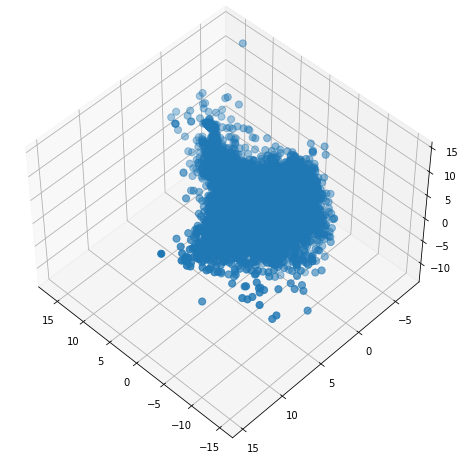

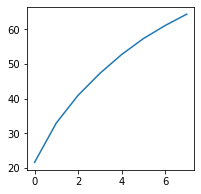

In [62]:
#plot
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(X[:, 0], X[:, 1], X[:, 2],s=50)
plt.show();

#Cumulative Variance explains
fig = plt.figure(1, figsize=(3, 3))
var = pca.explained_variance_ratio_
var1 = np.cumsum(np.round(var, decimals=4)*100)
plt.plot(var1)
plt.show();

In [63]:
li_ = range(2,8)
r, center_ = kmeans_clustering(df=df_[li_pca+li_2keep], range_n_clusters=li_, drop_col_list=li_2keep)
df_['clustering_ALL'] = r
display(df_[li_2keep+li_pca+['clustering_ALL']].head(3))
print(df_daily.shape)
df_daily = pd.merge(df_daily, df_[li_2keep+li_pca+['clustering_ALL']], on=['HenID','level'], how='left')
print(df_daily.shape)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For n_clusters = 2 The average silhouette_score is : 0.22161311246181564
For n_clusters = 3 The average silhouette_score is : 0.21432868766310004
For n_clusters = 4 The average silhouette_score is : 0.21320939626664054
For n_clusters = 5 The average silhouette_score is : 0.20562540141867075
For n_clusters = 6 The average silhouette_score is : 0.16032586913902744
For n_clusters = 7 The average silhouette_score is : 0.16969180901265413
Please let me know the numbers of clusters you want to search for 3
(30130, 8)


,HenID,level,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,clustering_ALL
6,hen_1,2020-10-06,6.452847,0.506433,1.935720,4.608001,-0.765068,4.071714,1.827943,3.683409,1
7,hen_1,2020-10-07,9.151482,-0.143763,2.381624,-1.022409,3.627691,3.482573,-1.532896,-0.158916,1
10,hen_1,2020-10-12,6.372797,0.370107,0.324987,0.312740,-0.117179,1.009985,1.052025,1.089848,1


(42103, 208)
(42103, 217)


In [64]:
#### one table with mean for each variable within each clusters
li_df = []
for k in df_['clustering_ALL'].unique():
    df0 = df_[df_['clustering_ALL']==k][li_all+li_pca]
    li_df.append(df0.mean())
df_m = pd.concat(li_df,axis=1)
df_m.to_csv(os.path.join(path_cluster, 'AllVariable_clusters_properties.csv'))
print(df_m.shape)
df_m.head(10)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(49, 3)


,0,1,2
variance_duration,2.548358e+07,1.407123e+06,1.080990e+06
median_duration,8.056445e+02,3.805509e+02,4.884529e+02
max_duration,1.596264e+04,6.164575e+03,5.293758e+03
Total_number_zone,4.322733e+00,4.987487e+00,4.576239e+00
#trnight/#totaltr,7.909501e-03,6.121859e-03,1.043827e-02
vertical_travel_distance,3.557533e+01,6.778040e+01,7.331560e+01
night_Total_number_transition,2.195096e-01,4.698625e-01,7.590792e-01
Consistent_Night_Zone5Days,8.132562e-01,6.674304e-01,5.757095e-01
duration_1_Zone,3.506682e+02,3.764494e+03,4.658055e+02
duration_2_Zone,1.025247e+04,2.029288e+04,2.588879e+04


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


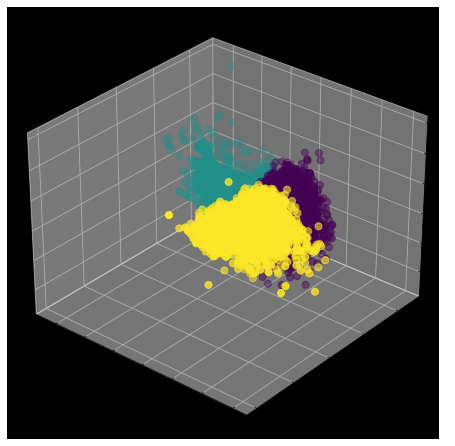

In [65]:
#plot with pca component in 3D, to have a visual on how well is the clustering working
df_plt = df_.copy()
df_plt['clustering_ALL'] = df_plt['clustering_ALL'].map({0:'r',1:'g',2:'black',3:'blue',4:'y',5:'lightgreen',6:'grey',
                                                       7:'indianred',8:'chocolate',9:'chartreuse',10:'deepping'})
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=130) #change number to change point's places on the figure
plt.gca().patch.set_facecolor('black')
ax.scatter(df_['PC0'], df_['PC1'], df_['PC2'], s=50, c=df_['clustering_ALL'].tolist())
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.show()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


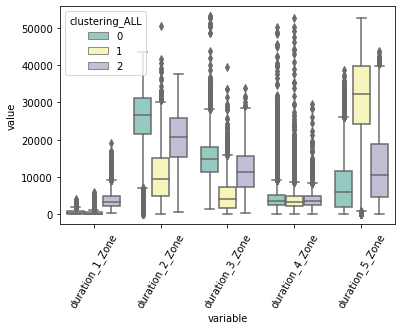

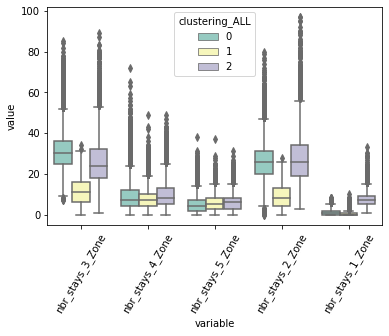

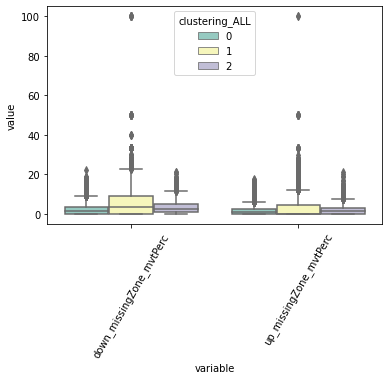

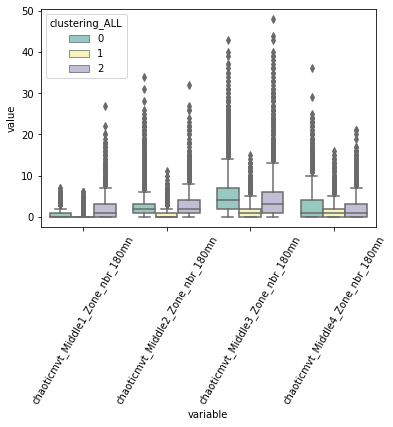

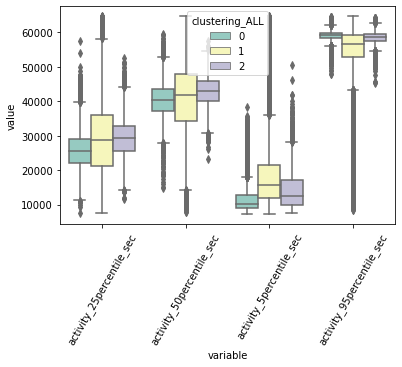

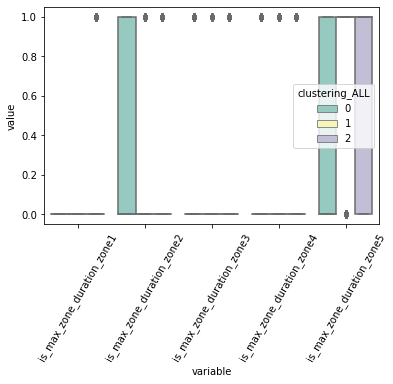

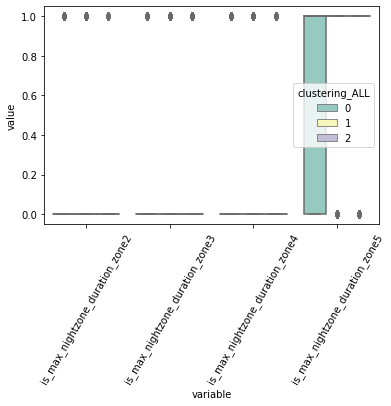

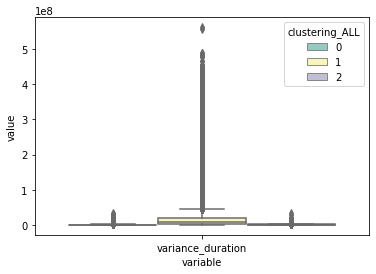

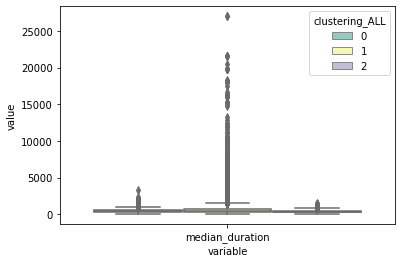

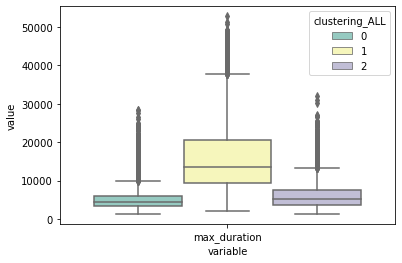

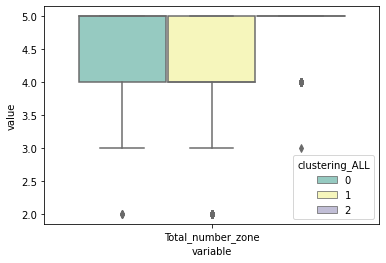

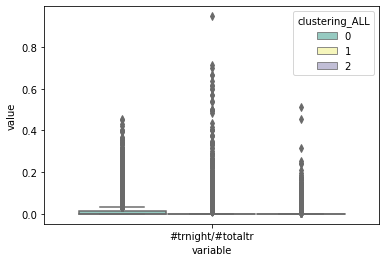

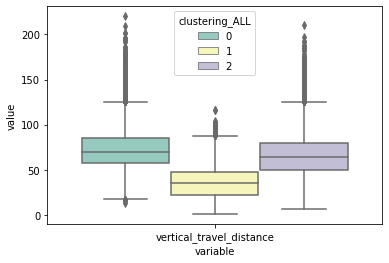

ERROR:  duration_last-firsttransition_mn   Neither the `x` nor `y` variable appears to be numeric.


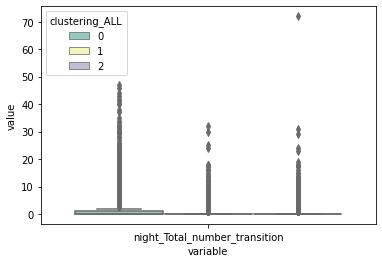

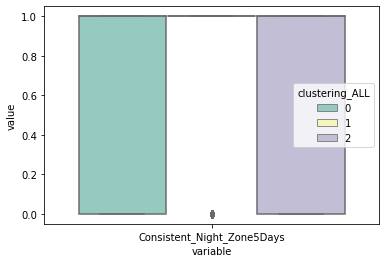

In [66]:
#### plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
nbr = 0
for li_ in li_gali:
    #display(df_[['clustering_coeff','HenID','level']+li_gali[0]].head(3))
    df_plt = pd.melt(df_, id_vars=['clustering_ALL','HenID','level'], value_vars=li_).reset_index(drop=True)
    #print(df_plt.shape)
    #display(df_plt.head(3))
    ax = sns.boxplot(x="variable", y="value", hue="clustering_ALL",data=df_plt, palette="Set3")
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=60)
    plt.savefig(os.path.join(path_cluster,'NestBox_'+str(nbr)+'.png'), bbox_inches='tight')
    nbr = nbr+1
    plt.show();
for x in li_general_activity:
    if not any([any([x in li]) for li in li_gali]):
        try:
            df_plt = pd.melt(df_, id_vars=['clustering_ALL','HenID','level'], value_vars=x).reset_index(drop=True)
            #display(df_plt.head(3))
            ax = sns.boxplot(x="variable", y="value", hue="clustering_ALL",data=df_plt, palette="Set3")
            plt.savefig(os.path.join(path_cluster,'AllVariables_'+x.replace('/','')+'.png'), bbox_inches='tight')
            plt.show();
        except Exception as e:
            print('ERROR: ',x, ' ',e)

#ONCE WE HAVE NESTBOX
#plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
for li_ in li_nb:
    #display(df_[['clustering_coeff','HenID','level']+li_gali[0]].head(3))
    df_plt = pd.melt(df_, id_vars=['clustering_coeff','HenID','level'], value_vars=li_).reset_index(drop=True)
    #print(df_plt.shape)
    #display(df_plt.head(3))
    ax = sns.boxplot(x="variable", y="value", hue="clustering_coeff",data=df_plt, palette="Set3")
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=60)
    plt.show();
for x in li_nestbox_usage:
    if not any([any([x in li]) for li in li_nb]):
        df_plt = pd.melt(df_, id_vars=['clustering_coeff','HenID','level'], value_vars=x).reset_index(drop=True)
        #display(df_plt.head(3))
        ax = sns.boxplot(x="variable", y="value", hue="clustering_coeff",data=df_plt, palette="Set3")
        plt.show();

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


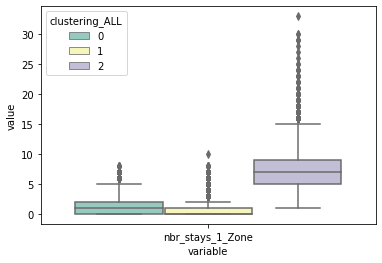

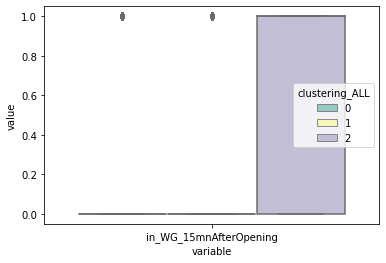

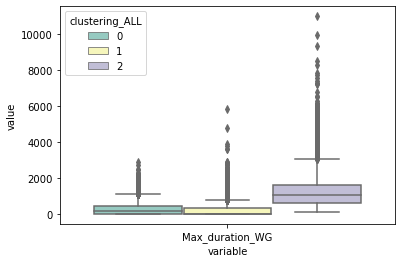

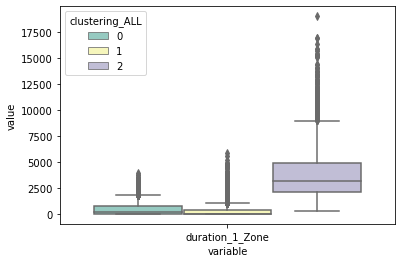

In [67]:
#### plot boxplot for each x variable in each cluster (given by the 'cluster_name' column from df)
for x in li_WG_usage:
    df_plt = pd.melt(df_, id_vars=['clustering_ALL','HenID','level'], value_vars=x).reset_index(drop=True)
    ax = sns.boxplot(x="variable", y="value", hue="clustering_ALL",data=df_plt, palette="Set3")
    plt.savefig(os.path.join(path_cluster,'AllVariables_'+x+'.png'), bbox_inches='tight')
    plt.show();

# Save variables

In [68]:
df_daily.to_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';', index=False)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Clustering Visuals

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


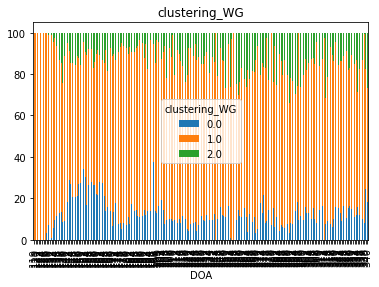

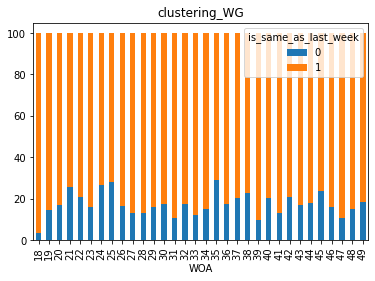

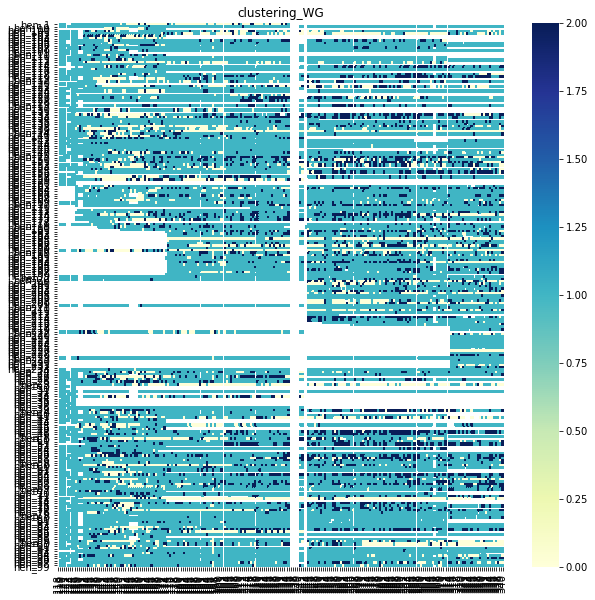

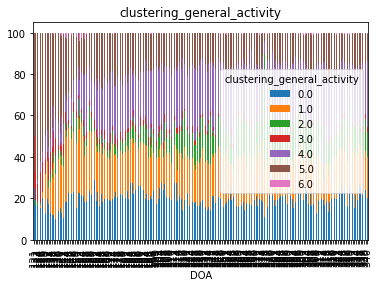

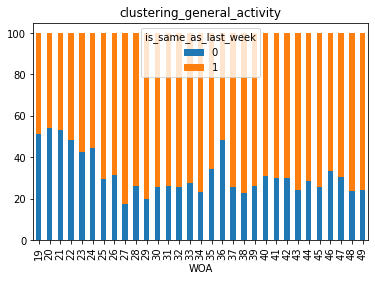

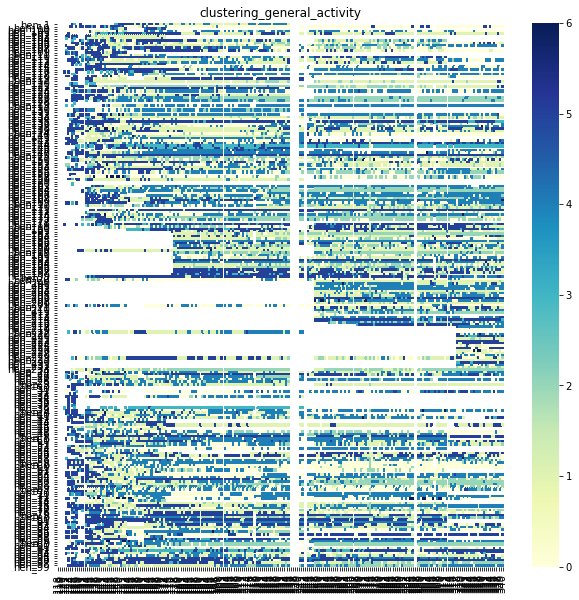

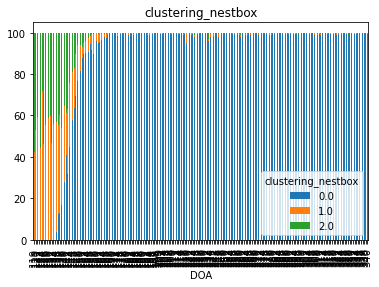

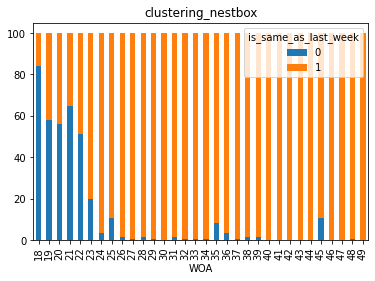

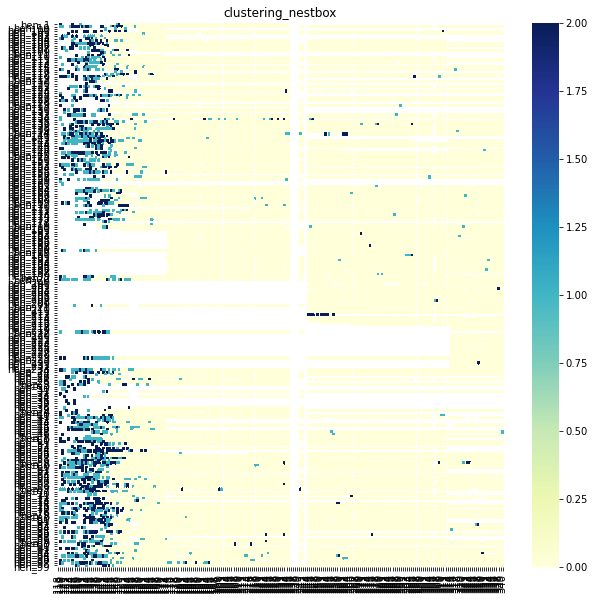

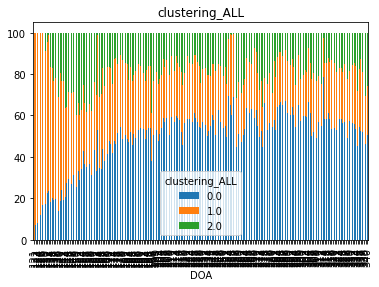

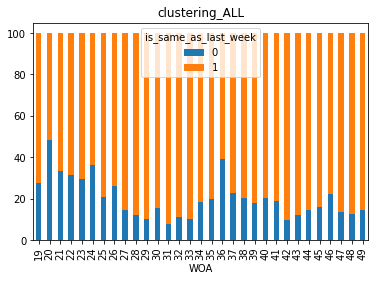

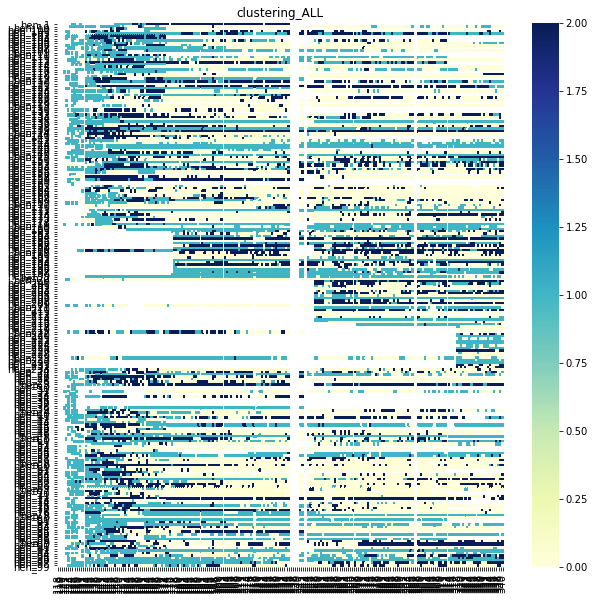

In [69]:
li_cl = ['clustering_WG', 'clustering_general_activity', 'clustering_nestbox', 'clustering_ALL']
for cl_var in li_cl:

    ############ stacked barplot
    df_plot = df_daily[~df_daily[cl_var].isnull()].sort_values('DOA', ascending=True).copy()
    df_plot = df_plot.groupby([cl_var,'DOA']).size().reset_index()
    #display(df_plot.head(3))
    df_plot = df_plot.pivot(columns=cl_var, index='DOA', values=0).reset_index()
    #display(df_plot.head(3))
    df_plot = df_plot.set_index('DOA')
    df_plot.fillna(0,inplace=True)
    #display(df_plot.head(3))
    df_plot_normalized = df_plot.div(df_plot.sum(axis=1)/100, axis=0)
    #display(df_plot_normalized.head(3))
    #df_plot.plot(kind='bar',stacked=True);
    df_plot_normalized.plot(kind='bar',stacked=True);
    plt.title(cl_var)
    plt.savefig(os.path.join(path_cluster,cl_var+'_ClusterRepartition.png'), bbox_inches='tight')
    plt.show()
    
    ############ plot overall consistency: % hens taht have the same cluster that week as the week before
    df_plot = df_daily[~df_daily[cl_var].isnull()].sort_values('DOA', ascending=True).copy()
    df_plot = df_plot.groupby(['WOA','HenID'])[cl_var].agg(lambda x: list(x)).reset_index()
    df_plot['main_cluster'] = df_plot[cl_var].map(lambda x: max(Counter(x).items(), key=operator.itemgetter(1))[0])
    df_plot['last_week_main_cluster'] = df_plot.apply(lambda x: df_plot[(df_plot['HenID']==x['HenID']) & \
                                                                      (df_plot['WOA']==x['WOA']-1)]['main_cluster'].values, axis=1)
    df_plot['last_week_main_cluster'] = df_plot['last_week_main_cluster'].map(lambda x: x[0] if len(x)>0 else np.nan)
    df_plot['is_same_as_last_week'] = df_plot.apply(lambda x: int(x['last_week_main_cluster']==x['main_cluster']), axis=1)
    #TODO BEFORE SAVING: add rules when there is two main cluster!! i.e. by cecking more/less days)
    #remove the frist week of age (i.w. WOA=17)
    df_plot = df_plot[df_plot['WOA']!=min(df_plot['WOA'].unique())]
    #display(df_plot.head(2))
    #display(df_plot.tail(2))
    df_plot = df_plot.groupby(['WOA','is_same_as_last_week']).size().reset_index()
    #display(df_plot.head(3))
    df_plot = df_plot.pivot(columns='is_same_as_last_week', index='WOA', values=0).reset_index()
    df_plot = df_plot.set_index('WOA')
    #display(df_plot.head(3))
    df_plot_normalized = df_plot.div(df_plot.sum(axis=1)/100, axis=0)
    #display(df_plot_normalized.head(3))
    #df_plot.plot(kind='bar',stacked=True);
    df_plot_normalized.plot(kind='bar',stacked=True);
    plt.title(cl_var)
    plt.savefig(os.path.join(path_cluster,cl_var+'_OverallConsistency.png'), bbox_inches='tight')
    plt.show();
     
    ############ plot per chicken:heatmap with x=DOA; y= HenID, value/color=clusterID
    df_daily = df_daily.sort_values('DOA', ascending=True)
    df_plt = df_daily[['HenID','DOA',cl_var]].pivot(index='HenID', columns='DOA', values=cl_var)
    y = df_plt.index
    df_plt = df_plt.reset_index(drop=True)
    #display(df_plt.head(3))
    M = df_plt.to_numpy()
    #print(M.shape)
    plt.figure(figsize=(10,10))
    sns.heatmap(M, xticklabels=df_plt.columns, yticklabels=y, cmap="YlGnBu")
    plt.title(cl_var)
    plt.savefig(os.path.join(path_cluster,cl_var+'_HensConsistency.png'), bbox_inches='tight')
    plt.show();

# Distribution testing

In [70]:
from scipy.stats import shapiro
from scipy.stats import normaltest
from termcolor import colored

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [71]:
def ShapiroTest(data, alpha=0.05):
    '''The tests assume that that the sample was drawn from a Gaussian distribution. 
    p <= alpha: reject H0, not normal.
    p > alpha: fail to reject H0, normal'''
    # normality test
    stat, p = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        #print_color((('%.3f: %.3f' % (sl, cv),'black'),('data looks normal (fail to reject H0)','green')))
        print(colored('Sample looks Gaussian (fail to reject H0)','green'))
    else:
        print(colored('Sample does not look Gaussian (reject H0)','red'))
    return(stat, p)
    
def AgostinosK2Test(data, alpha=0.05):
    '''D’Agostino’s K^2 Test'''
    # normality test
    stat, p = normaltest(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > alpha:
        print(colored('Sample looks Gaussian (fail to reject H0)','green'))
    else:
        print(colored('Sample does not look Gaussian (reject H0)','red'))
    return(stat, p)

def andersonTest(data):
    '''Anderson-Darling Test for normality test'''
    result = anderson(data)
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print(colored('%.3f: %.3f' % (sl, cv),'grey'), colored('data looks normal (fail to reject H0)','green'))
        else:
            print(colored('%.3f: %.3f' % (sl, cv),'grey'), colored('data does not look normal (reject H0)','red'))
    return result  

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [72]:
for v in li_weight:
    print('------------------------ '+v)
    print('ShapiroTest')
    stat, p = ShapiroTest(list(df_daily[v].dropna()))
    print('D’Agostino’s K^2 Test')
    stat, p = AgostinosK2Test(list(df_daily[v].dropna()))
    
    
    print('------ LOG TRANSFORMATION')
    data = np.log(list(df_daily[v].dropna()))
    if 0 in list(df_daily[v].dropna()):
        data = np.log(list(df_daily[v].dropna()+1))
    print('ShapiroTest')
    stat, p = ShapiroTest(data)
    print('D’Agostino’s K^2 Test')
    stat, p = AgostinosK2Test(data)
    

------------------------ 29-09 weight
ShapiroTest
Statistics=0.992, p=0.000
Sample does not look Gaussian (reject H0)
D’Agostino’s K^2 Test
Statistics=47.642, p=0.000
Sample does not look Gaussian (reject H0)
------ LOG TRANSFORMATION
ShapiroTest
Statistics=0.991, p=0.000
Sample does not look Gaussian (reject H0)
D’Agostino’s K^2 Test
Statistics=94.554, p=0.000
Sample does not look Gaussian (reject H0)
------------------------ 10-12 juin weight
ShapiroTest
Statistics=0.972, p=0.000
Sample does not look Gaussian (reject H0)
D’Agostino’s K^2 Test
Statistics=1340.090, p=0.000
Sample does not look Gaussian (reject H0)
------ LOG TRANSFORMATION
ShapiroTest
Statistics=0.952, p=0.000
Sample does not look Gaussian (reject H0)
D’Agostino’s K^2 Test
Statistics=3245.281, p=0.000
Sample does not look Gaussian (reject H0)
------------------------ weight 23-11-2020
ShapiroTest
Statistics=0.990, p=0.000
Sample does not look Gaussian (reject H0)
D’Agostino’s K^2 Test
Statistics=544.095, p=0.000
Sample

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\camil\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
